In [1]:
from pandas import DataFrame
from pandas import Series
from pandas import concat
from pandas import read_csv
from pandas import datetime
from sklearn.metrics import mean_squared_error
from sklearn.preprocessing import MinMaxScaler
from keras.models import Sequential
from keras.layers import Dense
from keras.layers import LSTM
from math import sqrt
from matplotlib import pyplot
import numpy

Using TensorFlow backend.
/usr/local/lib/python3.7/site-packages/tensorflow/python/framework/dtypes.py:516: FutureWarning: Passing (type, 1) or '1type' as a synonym of type is deprecated; in a future version of numpy, it will be understood as (type, (1,)) / '(1,)type'.
  _np_qint8 = np.dtype([("qint8", np.int8, 1)])
/usr/local/lib/python3.7/site-packages/tensorflow/python/framework/dtypes.py:517: FutureWarning: Passing (type, 1) or '1type' as a synonym of type is deprecated; in a future version of numpy, it will be understood as (type, (1,)) / '(1,)type'.
  _np_quint8 = np.dtype([("quint8", np.uint8, 1)])
/usr/local/lib/python3.7/site-packages/tensorflow/python/framework/dtypes.py:518: FutureWarning: Passing (type, 1) or '1type' as a synonym of type is deprecated; in a future version of numpy, it will be understood as (type, (1,)) / '(1,)type'.
  _np_qint16 = np.dtype([("qint16", np.int16, 1)])
/usr/local/lib/python3.7/site-packages/tensorflow/python/framework/dtypes.py:519: FutureWarn

In [2]:
# date-time parsing function for loading the dataset
def parser(x):
	return datetime.strptime('190'+x, '%Y-%m')

# frame a sequence as a supervised learning problem
def timeseries_to_supervised(data, lag=1):
	df = DataFrame(data)
	columns = [df.shift(i) for i in range(1, lag+1)]
	columns.append(df)
	df = concat(columns, axis=1)
	df.fillna(0, inplace=True)
	return df

# create a differenced series
def difference(dataset, interval=1):
	diff = list()
	for i in range(interval, len(dataset)):
		value = dataset[i] - dataset[i - interval]
		diff.append(value)
	return Series(diff)

# invert differenced value
def inverse_difference(history, yhat, interval=1):
	return yhat + history[-interval]

# scale train and test data to [-1, 1]
def scale(train, test):
	# fit scaler
	scaler = MinMaxScaler(feature_range=(-1, 1))
	scaler = scaler.fit(train)
	# transform train
	train = train.reshape(train.shape[0], train.shape[1])
	train_scaled = scaler.transform(train)
	# transform test
	test = test.reshape(test.shape[0], test.shape[1])
	test_scaled = scaler.transform(test)
	return scaler, train_scaled, test_scaled

# inverse scaling for a forecasted value
def invert_scale(scaler, X, value):
	new_row = [x for x in X] + [value]
	array = numpy.array(new_row)
	array = array.reshape(1, len(array))
	inverted = scaler.inverse_transform(array)
	return inverted[0, -1]

# fit an LSTM network to training data
def fit_lstm(train, batch_size, nb_epoch, neurons):
	X, y = train[:, 0:-1], train[:, -1]
	X = X.reshape(X.shape[0], 1, X.shape[1])
	model = Sequential()
	model.add(LSTM(neurons, batch_input_shape=(batch_size, X.shape[1], X.shape[2]), stateful=True))
	model.add(Dense(1))
	model.compile(loss='mean_squared_error', optimizer='adam')
	for i in range(nb_epoch):
		model.fit(X, y, epochs=1, batch_size=batch_size, verbose=0, shuffle=False)
		model.reset_states()
	return model

# make a one-step forecast
def forecast_lstm(model, batch_size, X):
	X = X.reshape(1, 1, len(X))
	yhat = model.predict(X, batch_size=batch_size)
	return yhat[0,0]

Month
1901-01-01    266.0
1901-02-01    145.9
1901-03-01    183.1
1901-04-01    119.3
1901-05-01    180.3
1901-06-01    168.5
1901-07-01    231.8
1901-08-01    224.5
1901-09-01    192.8
1901-10-01    122.9
1901-11-01    336.5
1901-12-01    185.9
1902-01-01    194.3
1902-02-01    149.5
1902-03-01    210.1
1902-04-01    273.3
1902-05-01    191.4
1902-06-01    287.0
1902-07-01    226.0
1902-08-01    303.6
1902-09-01    289.9
1902-10-01    421.6
1902-11-01    264.5
1902-12-01    342.3
1903-01-01    339.7
1903-02-01    440.4
1903-03-01    315.9
1903-04-01    439.3
1903-05-01    401.3
1903-06-01    437.4
1903-07-01    575.5
1903-08-01    407.6
1903-09-01    682.0
1903-10-01    475.3
1903-11-01    581.3
1903-12-01    646.9
Name: Level, dtype: float64


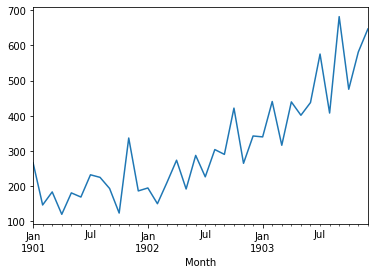

In [3]:
# load dataset
series = read_csv('fill_level.csv', header=0, parse_dates=[0], index_col=0, squeeze=True, date_parser=parser)

# summarize first few rows
print(series)
# line plot
series.plot()
pyplot.show()

In [4]:
# transform data to be stationary
raw_values = series.values
diff_values = difference(raw_values, 1)

# transform data to be supervised learning
supervised = timeseries_to_supervised(diff_values, 1)
supervised_values = supervised.values

# split data into train and test-sets
train, test = supervised_values[0:-12], supervised_values[-12:]

# transform the scale of the data
scaler, train_scaled, test_scaled = scale(train, test)

## Robust model with multiple experiments

In [5]:
# repeat experiment
repeats = 30
error_scores = list()
for r in range(repeats):
	# fit the model
	lstm_model = fit_lstm(train_scaled, 1, 3000, 4)
	# forecast the entire training dataset to build up state for forecasting
	train_reshaped = train_scaled[:, 0].reshape(len(train_scaled), 1, 1)
	lstm_model.predict(train_reshaped, batch_size=1)
	# walk-forward validation on the test data
	predictions = list()
	for i in range(len(test_scaled)):
		# make one-step forecast
		X, y = test_scaled[i, 0:-1], test_scaled[i, -1]
		yhat = forecast_lstm(lstm_model, 1, X)
		# invert scaling
		yhat = invert_scale(scaler, X, yhat)
		# invert differencing
		yhat = inverse_difference(raw_values, yhat, len(test_scaled)+1-i)
		# store forecast
		predictions.append(yhat)
	# report performance
	rmse = sqrt(mean_squared_error(raw_values[-12:], predictions))
	print('%d) Test RMSE: %.3f' % (r+1, rmse))
	error_scores.append(rmse)

W1108 11:33:35.085251 4695870912 deprecation_wrapper.py:119] From /usr/local/lib/python3.7/site-packages/keras/backend/tensorflow_backend.py:64: The name tf.get_default_graph is deprecated. Please use tf.compat.v1.get_default_graph instead.

W1108 11:33:35.111554 4695870912 deprecation_wrapper.py:119] From /usr/local/lib/python3.7/site-packages/keras/backend/tensorflow_backend.py:497: The name tf.placeholder is deprecated. Please use tf.compat.v1.placeholder instead.

W1108 11:33:35.115319 4695870912 deprecation_wrapper.py:119] From /usr/local/lib/python3.7/site-packages/keras/backend/tensorflow_backend.py:3636: The name tf.random_uniform is deprecated. Please use tf.random.uniform instead.

W1108 11:33:35.209898 4695870912 deprecation.py:506] From /usr/local/lib/python3.7/site-packages/keras/backend/tensorflow_backend.py:680: calling Constant.__init__ (from tensorflow.python.ops.init_ops) with dtype is deprecated and will be removed in a future version.
Instructions for updating:
Call

1) Test RMSE: 133.201
2) Test RMSE: 199.283
3) Test RMSE: 134.086
4) Test RMSE: 146.954
5) Test RMSE: 97.035
6) Test RMSE: 70.778
7) Test RMSE: 96.996
8) Test RMSE: 291.051
9) Test RMSE: 229.754
10) Test RMSE: 97.525
11) Test RMSE: 106.483
12) Test RMSE: 134.117
13) Test RMSE: 91.243
14) Test RMSE: 317.426
15) Test RMSE: 99.297
16) Test RMSE: 228.534
17) Test RMSE: 96.906
18) Test RMSE: 152.183
19) Test RMSE: 367.937
20) Test RMSE: 89.463
21) Test RMSE: 92.549
22) Test RMSE: 213.216
23) Test RMSE: 120.185
24) Test RMSE: 89.603
25) Test RMSE: 109.655
26) Test RMSE: 124.663
27) Test RMSE: 86.520
28) Test RMSE: 196.482
29) Test RMSE: 89.082
30) Test RMSE: 176.765


             rmse
count   30.000000
mean   149.299097
std     75.414591
min     70.777546
25%     96.928868
50%    122.423965
75%    191.553180
max    367.936719


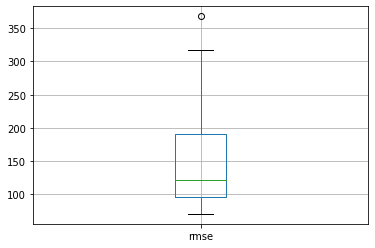

In [6]:
# summarize results
results = DataFrame()
results['rmse'] = error_scores
print(results.describe())
results.boxplot()
pyplot.show()

## Single LSTM

Month=1, Predicted=338.639556, Expected=339.700000
Month=2, Predicted=395.361862, Expected=440.400000
Month=3, Predicted=416.703594, Expected=315.900000
Month=4, Predicted=476.458688, Expected=439.300000
Month=5, Predicted=469.090143, Expected=401.300000
Month=6, Predicted=566.094903, Expected=437.400000
Month=7, Predicted=514.653989, Expected=575.500000
Month=8, Predicted=610.093637, Expected=407.600000
Month=9, Predicted=619.926673, Expected=682.000000
Month=10, Predicted=590.344147, Expected=475.300000
Month=11, Predicted=661.198072, Expected=581.300000
Month=12, Predicted=681.938335, Expected=646.900000
Test RMSE: 93.155


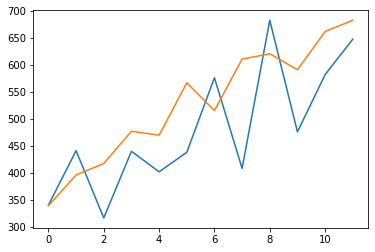

In [7]:
# fit the model
lstm_model = fit_lstm(train_scaled, 1, 3000, 4)
# forecast the entire training dataset to build up state for forecasting
train_reshaped = train_scaled[:, 0].reshape(len(train_scaled), 1, 1)
lstm_model.predict(train_reshaped, batch_size=1)

# walk-forward validation on the test data
predictions = list()
for i in range(len(test_scaled)):
	# make one-step forecast
	X, y = test_scaled[i, 0:-1], test_scaled[i, -1]
	yhat = forecast_lstm(lstm_model, 1, X)
	# invert scaling
	yhat = invert_scale(scaler, X, yhat)
	# invert differencing
	yhat = inverse_difference(raw_values, yhat, len(test_scaled)+1-i)
	# store forecast
	predictions.append(yhat)
	expected = raw_values[len(train) + i + 1]
	print('Month=%d, Predicted=%f, Expected=%f' % (i+1, yhat, expected))

# report performance
rmse = sqrt(mean_squared_error(raw_values[-12:], predictions))
print('Test RMSE: %.3f' % rmse)
# line plot of observed vs predicted
pyplot.plot(raw_values[-12:])
pyplot.plot(predictions)
pyplot.show()